# Probando en otros niveles de OTU
En este script lo que vamos a ver es el mejor modelo en diferentes niveles taxonomicos cogiendo los datos que solo tienen los OTUs que se dan al menos en el 80% de los samples

# Parte comun

In [1]:
#importamos paquetes
import sys
sys.path.append('Src/')
from data_modificado import * #hay funciones que estan cambiadas en este script para adaptralas a nuestro dataset
from train_2 import * #este hubo que modificar una linea tambien
from transfer_learning import * #hubo que modificart lo mismo que en train_2
from transfer_learning_FI import * #necesario para el Feature Importance
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import itertools as it

#funciones
def read_df(
              metadata_names=['age','Temperature','Precipitation3Days'],
              random_state=42,
              otu_filename='../Datasets/otu_table_all_80.csv',
              metadata_filename='../Datasets/metadata_table_all_80.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None).T
    #print(otu.head())
    otu = otu.set_index('otuids')
    otu = otu.astype('int32')
    metadata = pd.read_csv(metadata_filename)
    #print(metadata.head())
    metadata = metadata.set_index('X.SampleID')
    metadata.head()
    domain = metadata[metadata_names]
    #if 'INBREDS' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['INBREDS'], prefix='INBREDS')], axis=1)
    #    domain = domain.drop(['INBREDS'], axis=1)
    #elif 'Maize_Line' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['Maize_Line'], prefix='Maize_Line')], axis=1)
    #    domain = domain.drop(['Maize_Line'], axis=1) 
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    #print(df.head())
    #data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    #data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    df_microbioma = df[otu.columns]
    df_domain = df[domain.columns]
    df_domain.head()
    df_microbioma_train, df_microbioma_no_train, df_domain_train, df_domain_no_train = \
        train_test_split(df_microbioma, df_domain, test_size=0.1, random_state=random_state)
    # Transfer learning subset
    df_microbioma_test, df_microbioma_transfer_learning, df_domain_test, df_domain_transfer_learning = \
        train_test_split(df_microbioma_no_train, df_domain_no_train, test_size=0.1, random_state=random_state)
    df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test = \
        train_test_split(df_microbioma_transfer_learning, df_domain_transfer_learning, test_size=0.3, random_state=random_state)
    
    return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns
    #return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns


def train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                batch_size, epochs, train_callbacks):
    all_models = model_fn()
    model, encoder_bioma, encoder_domain, decoder_bioma = all_models
    metrics_prefix = None
    if encoder_bioma is not None and encoder_domain is not None:
        x_train = (m_train, d_train)
        y_train = (m_train, m_train, z_train)
        x_test = (m_test, d_test)
        y_test = (m_test, m_test, z_test)
    elif encoder_bioma is not None:
        x_train = m_train
        y_train = m_train
        x_test = m_test
        y_test = m_test
        metrics_prefix = 'bioma'
    elif encoder_domain is not None:
        x_train = d_train
        y_train = m_train
        x_test = d_test
        y_test = m_test
        metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
        batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    del val_dataset
    del train_dataset
    del x_train
    del y_train
    del x_test
    del y_test
    return r, all_models

def train_2(model_fn,
          data_microbioma,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          learning_rate_scheduler=ExpDecayScheluder(),
          random_seed=347,
          verbose=0):
    data_zeros_latent = np.zeros((data_microbioma.shape[0], latent_space), dtype=data_microbioma.dtype)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]
    if learning_rate_scheduler is not None:
        train_callbacks += [learning_rate_scheduler.make()]

    if folds <= 1:
        m_train, m_test = data_microbioma, data_microbioma
        d_train, d_test = data_domain, data_domain
        z_train, z_test = data_zeros_latent, data_zeros_latent
        tf.random.set_seed(random_seed)
        r, m = train_kfold(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                           batch_size, epochs, train_callbacks)
        results.append(r)
        models.append(m)

    else: #EL PROBLEMA ESTA AQUI, QUE HACE FALTA UN 
        kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
        tf.random.set_seed(random_seed)

        for train_index, test_index in kf.split(data_microbioma):
            m_train, m_test = data_microbioma[train_index], data_microbioma[test_index]
            #print(m_train)
            #d_train, d_test = data_domain[train_index], data_domain[test_index]
            if data_domain is None:
                d_train, d_test = None, None
            else:
                d_train, d_test = data_domain[train_index], data_domain[test_index]
            #print(d_train)
            #Esto de hacer el if else ha funcionado, pero no se si hace lo que debe bien
            z_train, z_test = data_zeros_latent[train_index], data_zeros_latent[test_index]
            r, m = train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                               batch_size, epochs, train_callbacks)
            results.append(r)
            models.append(m)
    return results, models

def perform_experiment_2_mod(cv_folds, epochs, batch_size, learning_rate, optimizer,
                       learning_rate_scheduler, input_transform, output_transform,
                       reconstruction_loss, latent_space, layers,
                       activation, activation_latent,
                       data_microbioma_train, data_domain_train,
                       show_results=True, device='/CPU:0'): #Show results cambiado de False  aTrue
    if input_transform is not None:
        input_transform = input_transform()
    #----------    
    if output_transform is not None:
        output_transform = output_transform()
    #----------      
    if reconstruction_loss.__class__.__name__ == 'MakeLoss':
        reconstruction_loss = reconstruction_loss.make()
    else:
        reconstruction_loss = reconstruction_loss()
    domain_layers = [l // 16 for l in layers] ####que es esto???? Esto es para las capas del domain
    #print(domain_layers)
    bioma_autoencoder = " -> ".join(["b"] +
                                    [str(l) for l in layers] +
                                    [str(latent_space)] +
                                    [str(l) for l in reversed(layers)] +
                                    ["b"])
    #---------- 
    #esto solo se utiliza para el texto, es irrelevante para nuestro error
    if data_domain_train is not None:
        domain_autoencoder = " -> ".join(["d"] +
                                     [str(l) for l in domain_layers] +
                                     [str(latent_space)] +
                                     [str(l) for l in reversed(layers)] +
                                     ["b"])
        
    else: 
        domain_autoencoder = " "
    #---------- 
    #donde se usa domain autoencoder?
    in_transform_name = input_transform.__class__.__name__ if input_transform else "none"
    out_transform_name = output_transform.__class__.__name__ if output_transform else "none"
    lr_scheduler_text = learning_rate_scheduler[
        1] if learning_rate_scheduler is not None else "none"
    lr_text = learning_rate if learning_rate_scheduler is not None else "constant = {}".format(
        learning_rate)
    learning_rate_scheduler = learning_rate_scheduler[
        0] if learning_rate_scheduler is not None else None
    optimizer = optimizer(learning_rate=learning_rate)
    #---------- 
    experiment_parameters = [
        ("Input transform", in_transform_name),
        ("Output transform", out_transform_name),
        ("Reconstruction Loss", reconstruction_loss.__class__.__name__),
        ("Latent Space", latent_space),
        ("Bioma Autoencoder", bioma_autoencoder),
        ("Domain Autoencoder", domain_autoencoder),
        ("Activation Encoder", activation),
        ("Activation Decoder", activation),
        ("Activation Latent", activation_latent),
        ("CV folds", cv_folds),
        ("Epochs", epochs),
        ("Batch Size", batch_size),
        ("Learning Rate Scheduler", lr_scheduler_text),
        ("Learning Rate", lr_text),
        ("Optimizer", optimizer.__class__.__name__),
    ]
    #----------  
    if show_results:
        md_text = ""
        md_text += "| Parameter             | Value         |\n"
        md_text += "|:----------------------|:--------------|\n"
        for n, v in experiment_parameters:
            md_text += "| {} | {} |\n".format(n, v)

        display(Markdown(md_text))
    #------------
    def create_model(print_data=False):
        bioma_shape=data_microbioma_train.shape[1]
        
        if data_domain_train is not None:
            domain_shape=data_domain_train.shape[1]
            #print("data_domain_train!=None")
        else:
            domain_shape=None
            #print("data_domain_train==None")
        models = autoencoder(bioma_shape=bioma_shape,
                             #bioma_shape=717,
                             domain_shape=domain_shape,
                             output_shape=bioma_shape,
                             #output_shape=717,
                             latent_space=latent_space,
                             bioma_layers=layers, #Esto es lo de [512,316]
                             domain_layers=domain_layers, #Esto son cada una de las layers divididas por 16
                             input_transform=input_transform,
                             output_transform=output_transform,
                             activation_function_encoder=activation,
                             activation_function_decoder=activation,
                             activation_function_latent=activation_latent)
        #Entiendo analizando lo demas que aqui NO esta el error
        #la funcion autoencoder esta en model.py (es la unica funcion en ese script)
        
        model, encoder_bioma, encoder_domain, decoder_bioma = models

        if print_data:
            plot_models(model, encoder_bioma, encoder_domain, decoder_bioma)
        compile_train(model,
                      encoder_bioma=encoder_bioma,
                      encoder_domain=encoder_domain,
                      reconstruction_error=reconstruction_loss,
                      encoded_comparison_error=losses.MeanAbsoluteError(),
                      metrics=get_experiment_metrics(input_transform, output_transform),
                      optimizer=optimizer)
        
        #print("He acabado create_model :)")
        return model, encoder_bioma, encoder_domain, decoder_bioma
    #-----------
    create_model(print_data=False)
    #-----------
    #Esta en esta seccion el problema, en train_2
    #print(data_domain_train)
    #print(latent_space)
    with tf.device(device):
        results, models = train_2(create_model,
                                data_microbioma_train,
                                data_domain_train,
                                latent_space=latent_space,
                                folds=cv_folds,
                                epochs=epochs,
                                batch_size=batch_size,
                                learning_rate_scheduler=learning_rate_scheduler,
                                verbose=-1)
    #----------
    validation_results = print_results(results, show_results=show_results)
    if show_results:
        display(Markdown("*************"))

    return experiment_parameters + validation_results, models, results

--------------------
Estas funciones comunes seran para guardar los datos y ver su error_per_OTU

In [2]:
##Creo que esto es comun, por lo que no hay que pasarlo a todas
def save_predicted_otu_table_and_latent(pred,pred_latent,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('Results/otus_'+suffix+'.tsv', index=True, header=True, sep='\t')

    df_latent = pd.DataFrame(pred_latent, index=sample_names)
    df_latent.T.to_csv('Results/latent_'+suffix+'.tsv', index=True, sep='\t')
    
    return df_otu, df_latent

#Compute metrics by OTU
# Absolute abundance transformed to TSS (with epsilon=1E-6)
def transform_to_rel_abundance(dataset):
    epsilon=1E-6
    sum_per_sample = dataset.sum(axis=1)
    num_samples = sum_per_sample.shape
    num_OTUs = np.shape(dataset)[-1] 
    sum_per_sample = sum_per_sample + (num_OTUs * epsilon)
    dividend=dataset+epsilon
    dataset_rel_abund = np.divide(dividend,sum_per_sample[:,None])
    #display(Markdown("{}</p>".format(np.array2string(actual_array,precision=6,floatmode='fixed'))))
    #actual_array.sum(axis=1)
    return dataset_rel_abund
def compute_relative_squared_error(actual,pred):
    rse_otu=np.zeros(actual.shape[1],dtype=np.float32)
    actual=actual_array.transpose()
    pred=pred_domain.transpose()
    # for each OTU
    for i, (act_otu,pred_otu) in enumerate(zip(actual,pred)):
        mean_otu = act_otu.mean()
        #display(Markdown("{} (mean(act)): {}</p>".format(i,mean_otu)))
        #display(Markdown("{} (act): {}</p>".format(i,np.array2string(act_otu,precision=8,floatmode='fixed'))))
        #display(Markdown("{} (pred): {}</p>".format(i,np.array2string(pred_otu,precision=8,floatmode='fixed'))))
        div_up=((pred_otu-act_otu)**2).sum()
        div_down=((pred_otu-mean_otu)**2).sum()
        rse_otu[i]=div_up/div_down
    return rse_otu, np.sqrt(rse_otu)

def save_errors_per_OTU(RSE,RRSE,otu_names,suffix=''):
    df_RSE = pd.DataFrame(RSE, index=otu_names, columns=['RSE'])
    df_RRSE = pd.DataFrame(RRSE, index=otu_names, columns=['RRSE'])
    df_error = df_RSE.join(df_RRSE)
    df_error.to_csv(suffix+'.tsv', index=True, header=True, sep='\t')
    
    return df_error

Funcion para sacar la feature Importance en cada uno de los modelos

In [3]:
def FI(): ##Hay que tener cuidado cuando se ejecute esto
    metric_results, _ = test_model_tl_noEnsemble_FI(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)
    error_original = metric_results["BrayCurtis"][0]
    metricas = dict()
    for i, variable in enumerate(nombres_metadatos):
        #print(variable)
        df1 = df_domain_test
        valores_BrayCurtis = []
        for j in range(0,10,1): #para sacar la desviacion tipica de cada uno
            #print(j)
            #shuffleamos la variable
            df1[variable] = np.random.permutation(df_domain_test[variable].values)
            data_domain_test_nueva = df1.to_numpy()
            #hacemos el modelo
            metric_results, _ = test_model_tl_noEnsemble_FI(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test_nueva)
            #valores_BrayCurtis.append(metric_results["BrayCurtis"][0]/error_original)
            valores_BrayCurtis.append(metric_results["BrayCurtis"][0]-error_original)#cualquiera de la dos, tanto division como resta vale, pero esta me parece mas facil de comparar
        metricas[variable] = valores_BrayCurtis
    return metricas

--------------------------
# Latent OTU

### Genus

In [4]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>92</b></p>

<b>loss</b>: 0.0763 (min: 0.0763, max: 0.0763)

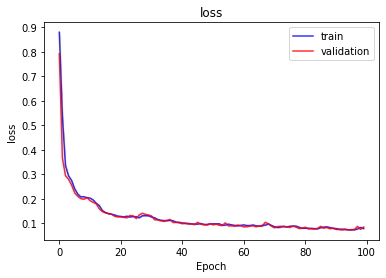

<b>bioma_mse</b>: 303918016.0000 (min: 303918016.0000, max: 303918016.0000)

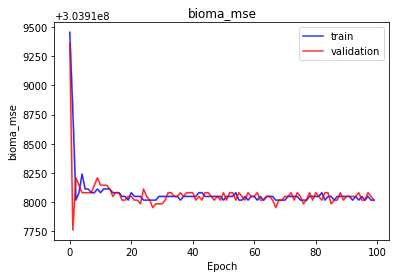

<b>bioma_mae</b>: 1614.6122 (min: 1614.6122, max: 1614.6122)

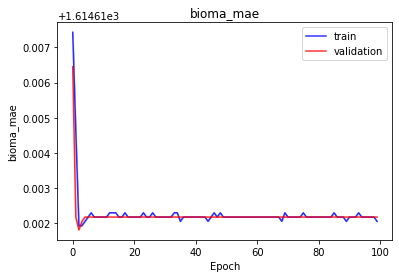

<b>bioma_mape</b>: 15420.7539 (min: 15420.7539, max: 15420.7539)

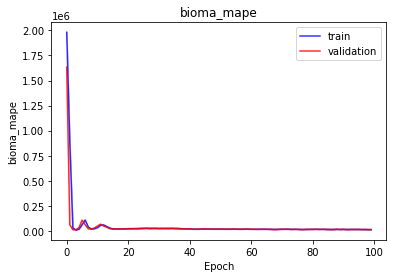

<b>bioma_BrayCurtis</b>: 0.0763 (min: 0.0763, max: 0.0763)

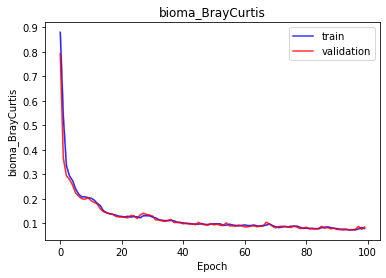

<b>bioma_pearson_corr</b>: 0.9960 (min: 0.9960, max: 0.9960)

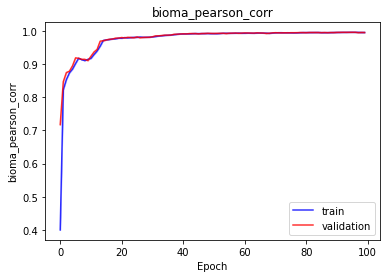

<b>bioma_jensen_shannon_divergence</b>: 0.1265 (min: 0.1265, max: 0.1265)

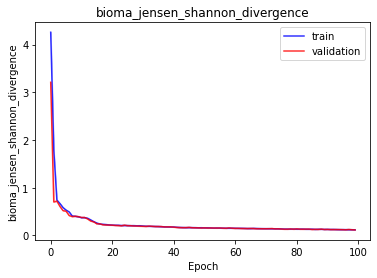

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.07629186660051346 | 0.07629186660051346 | 0.07629186660051346 |
| bioma_mse | 303918016.0 | 303918016.0 | 303918016.0 |
| bioma_mae | 1614.6121826171875 | 1614.6121826171875 | 1614.6121826171875 |
| bioma_mape | 15420.75390625 | 15420.75390625 | 15420.75390625 |
| bioma_BrayCurtis | 0.07629186660051346 | 0.07629186660051346 | 0.07629186660051346 |
| bioma_pearson_corr | 0.9960418939590454 | 0.9960418939590454 | 0.9960418939590454 |
| bioma_jensen_shannon_divergence | 0.12647759914398193 | 0.12647759914398193 | 0.12647759914398193 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.28253698348999023 | 0.28253698348999023 | 0.28253698348999023 |
| pearson_corr | 0.8607685565948486 | 0.8607685565948486 | 0.8607685565948486 |
| jensen_shannon_divergence | 0.4952954947948456 | 0.4952954947948456 | 0.4952954947948456 |


In [5]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [6]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_OTUcomida_genero.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomida_genero')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomida_genero')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_OTUcomida_genero')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_OTU_genus.csv",index=False)

### Family

In [7]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>91</b></p>

<b>loss</b>: 0.0583 (min: 0.0583, max: 0.0583)

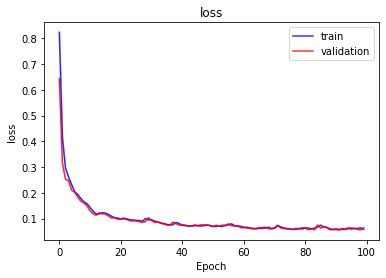

<b>bioma_mse</b>: 878693696.0000 (min: 878693696.0000, max: 878693696.0000)

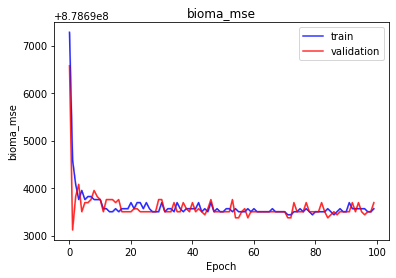

<b>bioma_mae</b>: 4677.9312 (min: 4677.9312, max: 4677.9312)

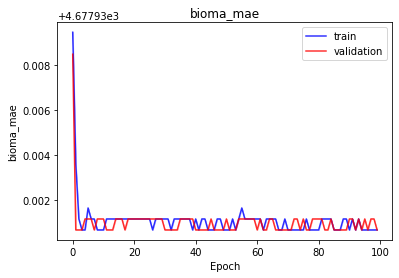

<b>bioma_mape</b>: 17845.1309 (min: 17845.1309, max: 17845.1309)

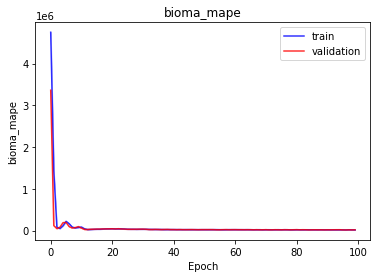

<b>bioma_BrayCurtis</b>: 0.0583 (min: 0.0583, max: 0.0583)

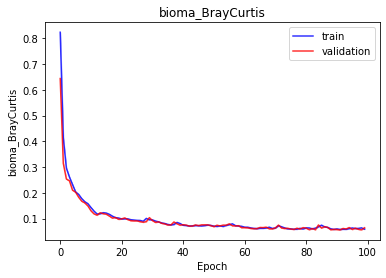

<b>bioma_pearson_corr</b>: 0.9964 (min: 0.9964, max: 0.9964)

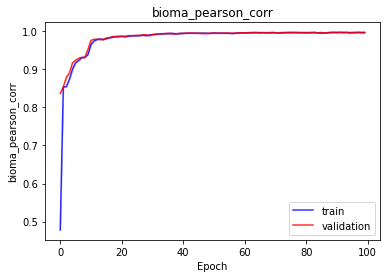

<b>bioma_jensen_shannon_divergence</b>: 0.0726 (min: 0.0726, max: 0.0726)

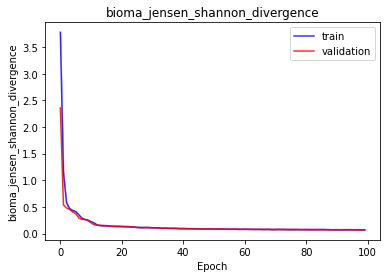

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.05834934860467911 | 0.05834934860467911 | 0.05834934860467911 |
| bioma_mse | 878693696.0 | 878693696.0 | 878693696.0 |
| bioma_mae | 4677.93115234375 | 4677.93115234375 | 4677.93115234375 |
| bioma_mape | 17845.130859375 | 17845.130859375 | 17845.130859375 |
| bioma_BrayCurtis | 0.05834934860467911 | 0.05834934860467911 | 0.05834934860467911 |
| bioma_pearson_corr | 0.9964309334754944 | 0.9964309334754944 | 0.9964309334754944 |
| bioma_jensen_shannon_divergence | 0.07262888550758362 | 0.07262888550758362 | 0.07262888550758362 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.28315186500549316 | 0.28315186500549316 | 0.28315186500549316 |
| pearson_corr | 0.8509417772293091 | 0.8509417772293091 | 0.8509417772293091 |
| jensen_shannon_divergence | 0.4468541145324707 | 0.4468541145324707 | 0.4468541145324707 |


In [8]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [9]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_OTUcomida_familia.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomida_familia')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomida_familia')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_OTUcomida_familia')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_OTU_familia.csv",index=False)

### Order

In [10]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>43</b></p>

<b>loss</b>: 0.2403 (min: 0.2403, max: 0.2403)

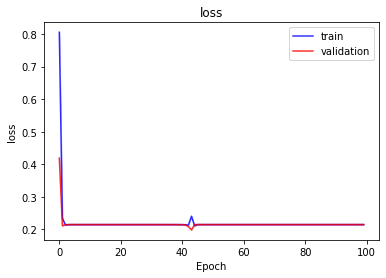

<b>bioma_mse</b>: 2787705600.0000 (min: 2787705600.0000, max: 2787705600.0000)

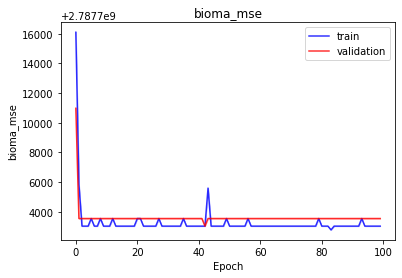

<b>bioma_mae</b>: 9028.4541 (min: 9028.4541, max: 9028.4541)

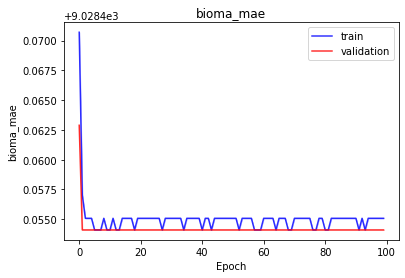

<b>bioma_mape</b>: 841.3532 (min: 841.3532, max: 841.3532)

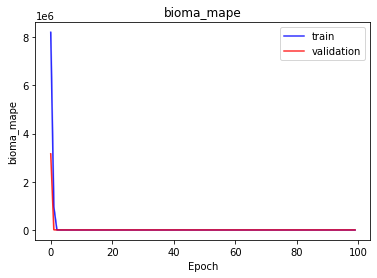

<b>bioma_BrayCurtis</b>: 0.2403 (min: 0.2403, max: 0.2403)

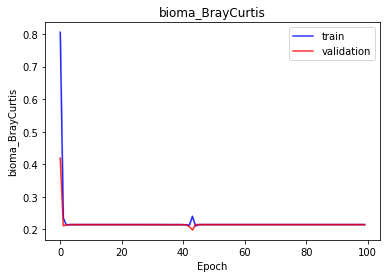

<b>bioma_pearson_corr</b>: 0.8857 (min: 0.8857, max: 0.8857)

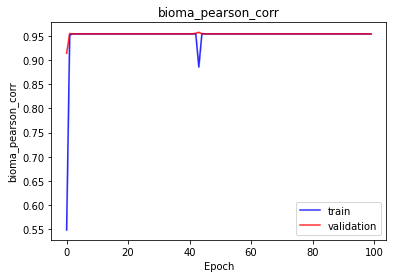

<b>bioma_jensen_shannon_divergence</b>: 0.4977 (min: 0.4977, max: 0.4977)

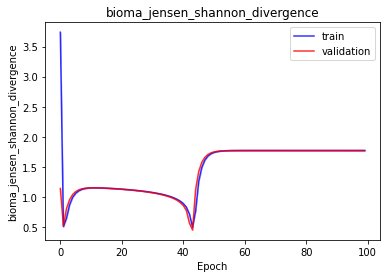

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.2403341382741928 | 0.2403341382741928 | 0.2403341382741928 |
| bioma_mse | 2787705600.0 | 2787705600.0 | 2787705600.0 |
| bioma_mae | 9028.4541015625 | 9028.4541015625 | 9028.4541015625 |
| bioma_mape | 841.3532104492188 | 841.3532104492188 | 841.3532104492188 |
| bioma_BrayCurtis | 0.2403341382741928 | 0.2403341382741928 | 0.2403341382741928 |
| bioma_pearson_corr | 0.8856687545776367 | 0.8856687545776367 | 0.8856687545776367 |
| bioma_jensen_shannon_divergence | 0.49770140647888184 | 0.49770140647888184 | 0.49770140647888184 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.21448461711406708 | 0.21448461711406708 | 0.21448461711406708 |
| pearson_corr | 0.9567595720291138 | 0.9567595720291138 | 0.9567595720291138 |
| jensen_shannon_divergence | 1.7745190858840942 | 1.7745190858840942 | 1.7745190858840942 |


In [11]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [12]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_OTUcomidas_orden.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomidas_orden')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomidas_orden')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_OTUcomidas_orden')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_OTU_orden.csv",index=False)

### Class

In [13]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>85</b></p>

<b>loss</b>: 0.0240 (min: 0.0240, max: 0.0240)

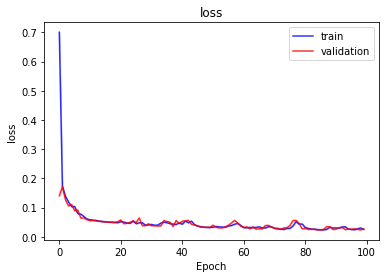

<b>bioma_mse</b>: 4695274496.0000 (min: 4695274496.0000, max: 4695274496.0000)

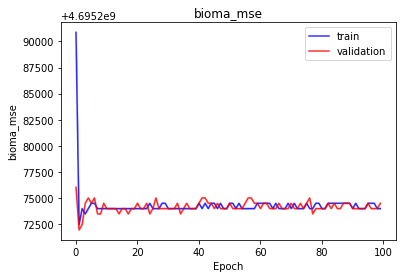

<b>bioma_mae</b>: 15206.2607 (min: 15206.2607, max: 15206.2607)

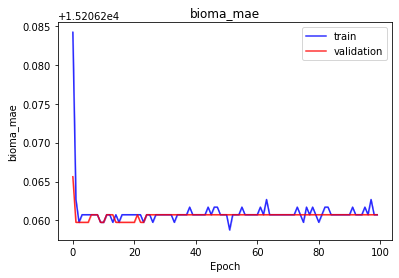

<b>bioma_mape</b>: 32083.4355 (min: 32083.4355, max: 32083.4355)

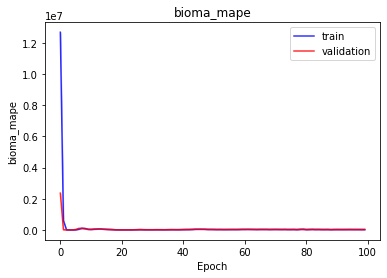

<b>bioma_BrayCurtis</b>: 0.0240 (min: 0.0240, max: 0.0240)

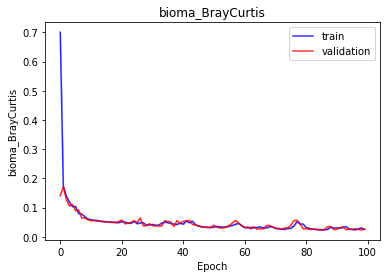

<b>bioma_pearson_corr</b>: 0.9991 (min: 0.9991, max: 0.9991)

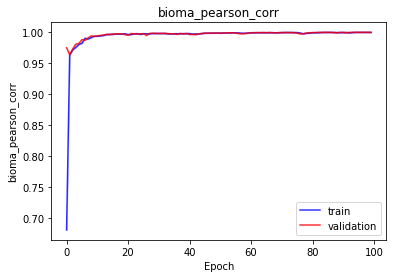

<b>bioma_jensen_shannon_divergence</b>: 0.0315 (min: 0.0315, max: 0.0315)

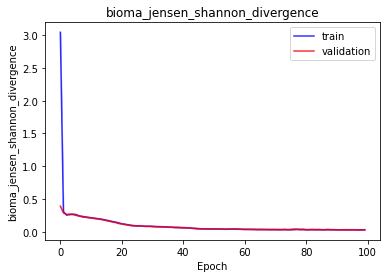

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.024021226912736893 | 0.024021226912736893 | 0.024021226912736893 |
| bioma_mse | 4695274496.0 | 4695274496.0 | 4695274496.0 |
| bioma_mae | 15206.2607421875 | 15206.2607421875 | 15206.2607421875 |
| bioma_mape | 32083.435546875 | 32083.435546875 | 32083.435546875 |
| bioma_BrayCurtis | 0.02402123063802719 | 0.02402123063802719 | 0.02402123063802719 |
| bioma_pearson_corr | 0.9990714192390442 | 0.9990714192390442 | 0.9990714192390442 |
| bioma_jensen_shannon_divergence | 0.03145654499530792 | 0.03145654499530792 | 0.03145654499530792 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.12619370222091675 | 0.12619370222091675 | 0.12619370222091675 |
| pearson_corr | 0.973768413066864 | 0.973768413066864 | 0.973768413066864 |
| jensen_shannon_divergence | 0.11980357766151428 | 0.11980357766151428 | 0.11980357766151428 |


In [14]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [15]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_OTUcomidas_clase.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomidas_clase')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomidas_clase')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_OTUcomidas_clase')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_OTU_clase.csv",index=False)

### Phylum

In [16]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.0149 (min: 0.0149, max: 0.0149)

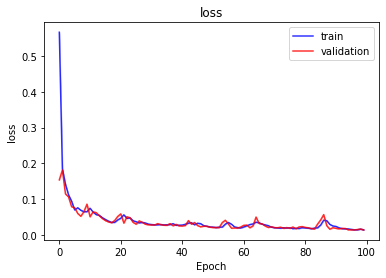

<b>bioma_mse</b>: 9952978944.0000 (min: 9952978944.0000, max: 9952978944.0000)

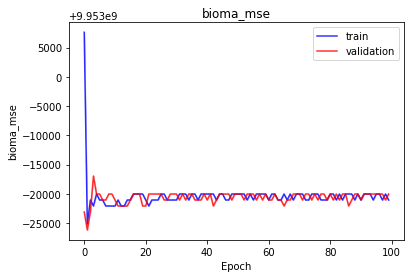

<b>bioma_mae</b>: 32181.6914 (min: 32181.6914, max: 32181.6914)

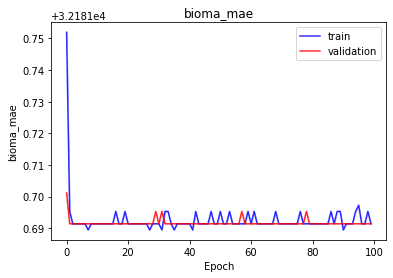

<b>bioma_mape</b>: 30208.1172 (min: 30208.1172, max: 30208.1172)

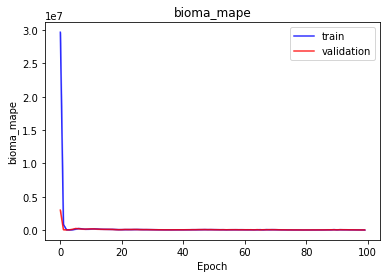

<b>bioma_BrayCurtis</b>: 0.0149 (min: 0.0149, max: 0.0149)

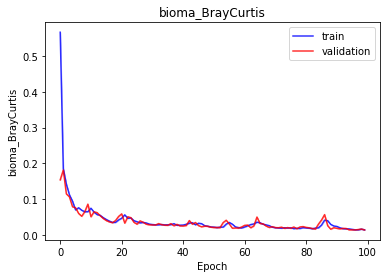

<b>bioma_pearson_corr</b>: 0.9995 (min: 0.9995, max: 0.9995)

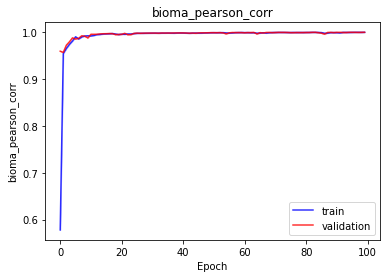

<b>bioma_jensen_shannon_divergence</b>: 0.0132 (min: 0.0132, max: 0.0132)

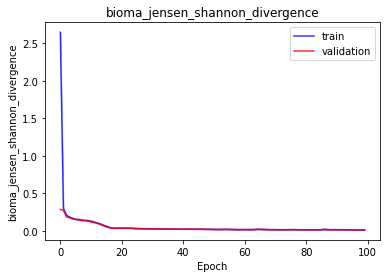

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.01491506863385439 | 0.01491506863385439 | 0.01491506863385439 |
| bioma_mse | 9952978944.0 | 9952978944.0 | 9952978944.0 |
| bioma_mae | 32181.69140625 | 32181.69140625 | 32181.69140625 |
| bioma_mape | 30208.1171875 | 30208.1171875 | 30208.1171875 |
| bioma_BrayCurtis | 0.01491506863385439 | 0.01491506863385439 | 0.01491506863385439 |
| bioma_pearson_corr | 0.9995429515838623 | 0.9995429515838623 | 0.9995429515838623 |
| bioma_jensen_shannon_divergence | 0.013186676427721977 | 0.013186676427721977 | 0.013186676427721977 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.13018980622291565 | 0.13018980622291565 | 0.13018980622291565 |
| pearson_corr | 0.9643223285675049 | 0.9643223285675049 | 0.9643223285675049 |
| jensen_shannon_divergence | 0.11454129964113235 | 0.11454129964113235 | 0.11454129964113235 |


In [17]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [18]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_OTUcomidas_filo.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_OTUcomidas_filo')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_OTUcomidas_filo')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_OTUcomidas_filo')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_OTU_filo.csv",index=False)

--------------------------
--------------------------
# Latent Combined

### Genus

In [19]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>88</b></p>

<b>loss</b>: 0.3818 (min: 0.3818, max: 0.3818)

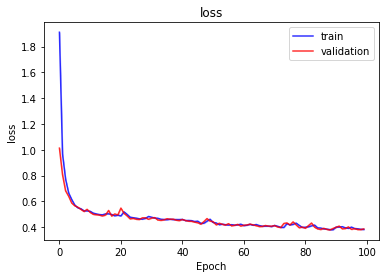

<b>bioma_loss</b>: 0.1132 (min: 0.1132, max: 0.1132)

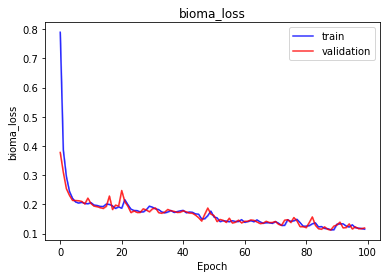

<b>domain_loss</b>: 0.2431 (min: 0.2431, max: 0.2431)

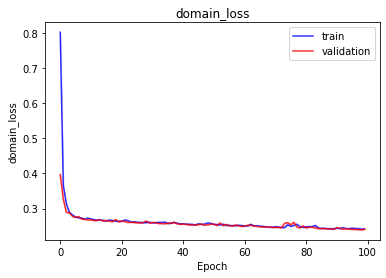

<b>latent_loss</b>: 0.0255 (min: 0.0255, max: 0.0255)

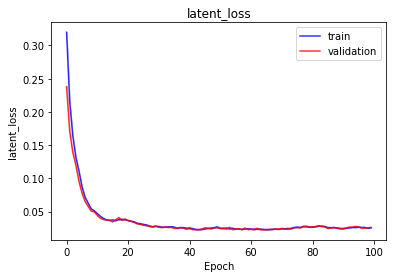

<b>bioma_mse</b>: 303918048.0000 (min: 303918048.0000, max: 303918048.0000)

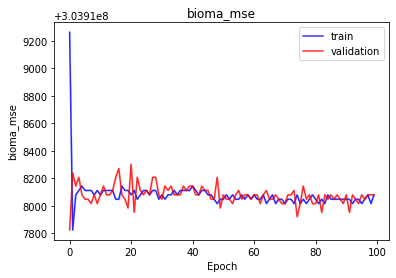

<b>bioma_mae</b>: 1614.6121 (min: 1614.6121, max: 1614.6121)

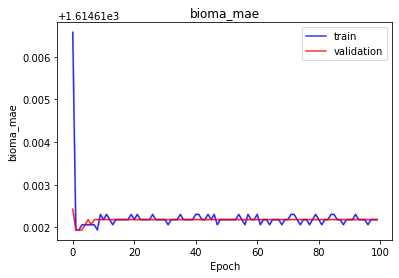

<b>bioma_mape</b>: 18374.1133 (min: 18374.1133, max: 18374.1133)

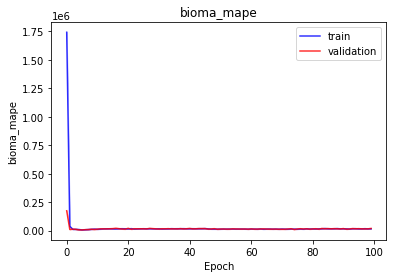

<b>bioma_BrayCurtis</b>: 0.1132 (min: 0.1132, max: 0.1132)

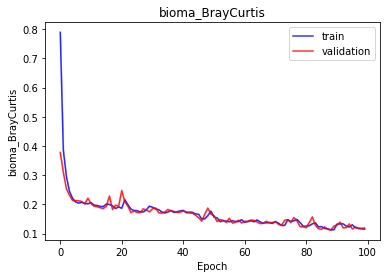

<b>bioma_pearson_corr</b>: 0.9825 (min: 0.9825, max: 0.9825)

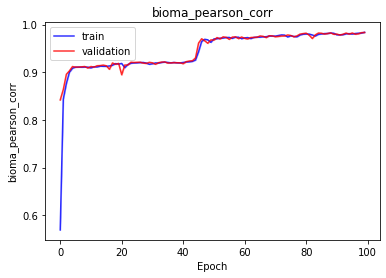

<b>bioma_jensen_shannon_divergence</b>: 0.2059 (min: 0.2059, max: 0.2059)

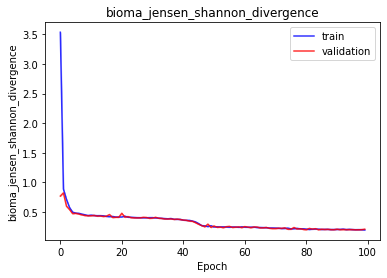

<b>domain_mse</b>: 303918144.0000 (min: 303918144.0000, max: 303918144.0000)

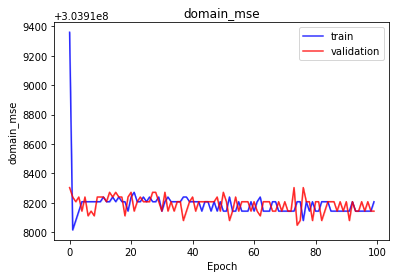

<b>domain_mae</b>: 1614.6121 (min: 1614.6121, max: 1614.6121)

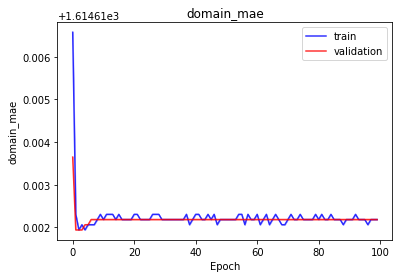

<b>domain_mape</b>: 14331.1602 (min: 14331.1602, max: 14331.1602)

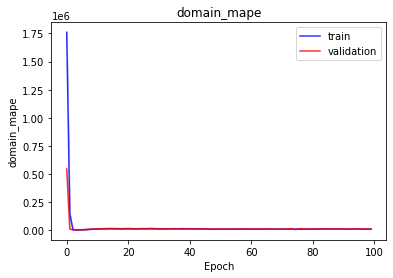

<b>domain_BrayCurtis</b>: 0.2431 (min: 0.2431, max: 0.2431)

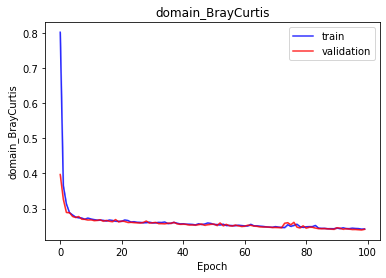

<b>domain_pearson_corr</b>: 0.8882 (min: 0.8882, max: 0.8882)

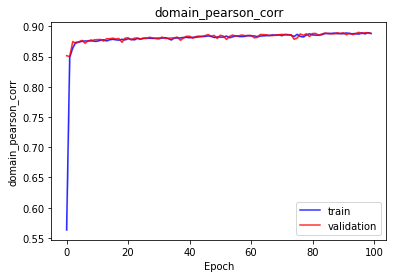

<b>domain_jensen_shannon_divergence</b>: 0.4634 (min: 0.4634, max: 0.4634)

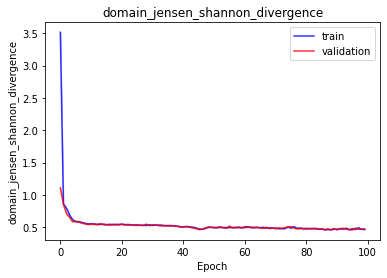

<b>latent_mae</b>: 0.0255 (min: 0.0255, max: 0.0255)

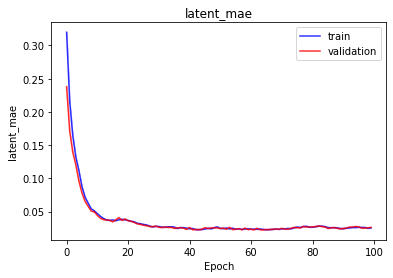

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.3817892372608185 | 0.3817892372608185 | 0.3817892372608185 |
| bioma_loss | 0.11317158490419388 | 0.11317158490419388 | 0.11317158490419388 |
| domain_loss | 0.24307411909103394 | 0.24307411909103394 | 0.24307411909103394 |
| latent_loss | 0.025543568655848503 | 0.025543568655848503 | 0.025543568655848503 |
| bioma_mse | 303918048.0 | 303918048.0 | 303918048.0 |
| bioma_mae | 1614.612060546875 | 1614.612060546875 | 1614.612060546875 |
| bioma_mape | 18374.11328125 | 18374.11328125 | 18374.11328125 |
| bioma_BrayCurtis | 0.11317158490419388 | 0.11317158490419388 | 0.11317158490419388 |
| bioma_pearson_corr | 0.9824759364128113 | 0.9824759364128113 | 0.9824759364128113 |
| bioma_jensen_shannon_divergence | 0.20586904883384705 | 0.20586904883384705 | 0.20586904883384705 |
| domain_mse | 303918144.0 | 303918144.0 | 303918144.0 |
| domain_mae | 1614.612060546875 | 1614.612060546875 | 1614.612060546875 |
| domain_mape | 14331.16015625 | 14331.16015625 | 14331.16015625 |
| domain_BrayCurtis | 0.24307411909103394 | 0.24307411909103394 | 0.24307411909103394 |
| domain_pearson_corr | 0.8882104754447937 | 0.8882104754447937 | 0.8882104754447937 |
| domain_jensen_shannon_divergence | 0.46344494819641113 | 0.46344494819641113 | 0.46344494819641113 |
| latent_mae | 0.025543568655848503 | 0.025543568655848503 | 0.025543568655848503 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.25990018248558044 | 0.25990018248558044 | 0.25990018248558044 |
| pearson_corr | 0.8844029307365417 | 0.8844029307365417 | 0.8844029307365417 |
| jensen_shannon_divergence | 0.4692198634147644 | 0.4692198634147644 | 0.4692198634147644 |


In [20]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [21]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_Combinedcomida_genero.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_Combinedcomida_genero')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_Combinedcomida_genero')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_Combinedcomida_genero')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_Combined_genus.csv",index=False)

### Family

In [22]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.3501 (min: 0.3501, max: 0.3501)

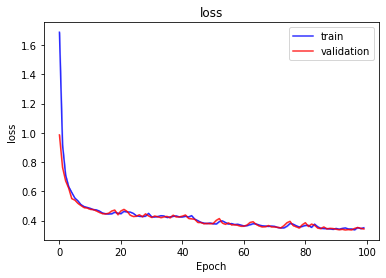

<b>bioma_loss</b>: 0.0977 (min: 0.0977, max: 0.0977)

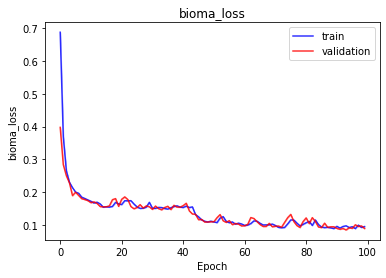

<b>domain_loss</b>: 0.2251 (min: 0.2251, max: 0.2251)

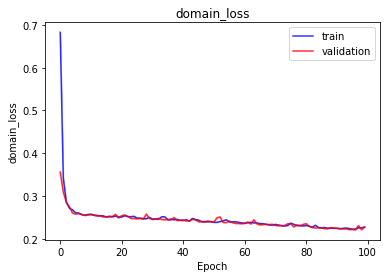

<b>latent_loss</b>: 0.0273 (min: 0.0273, max: 0.0273)

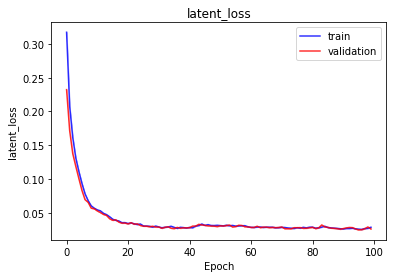

<b>bioma_mse</b>: 878693696.0000 (min: 878693696.0000, max: 878693696.0000)

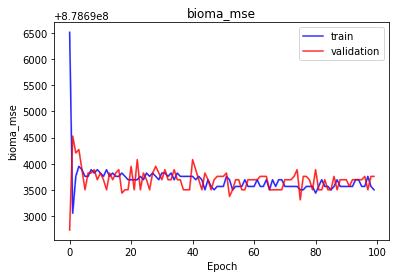

<b>bioma_mae</b>: 4677.9307 (min: 4677.9307, max: 4677.9307)

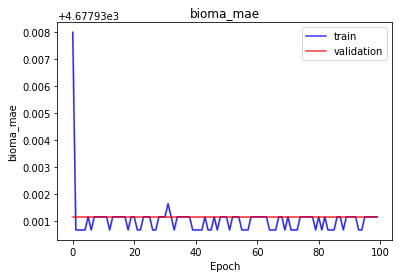

<b>bioma_mape</b>: 20991.0684 (min: 20991.0684, max: 20991.0684)

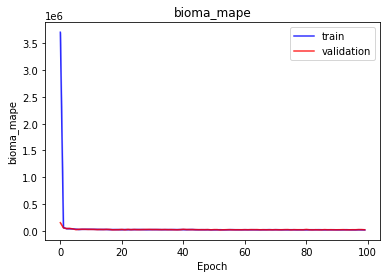

<b>bioma_BrayCurtis</b>: 0.0977 (min: 0.0977, max: 0.0977)

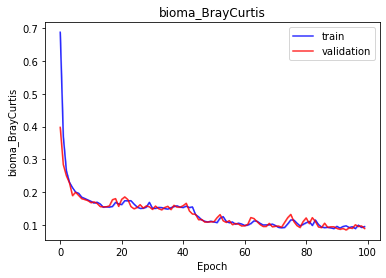

<b>bioma_pearson_corr</b>: 0.9883 (min: 0.9883, max: 0.9883)

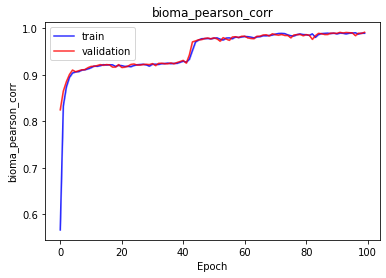

<b>bioma_jensen_shannon_divergence</b>: 0.1244 (min: 0.1244, max: 0.1244)

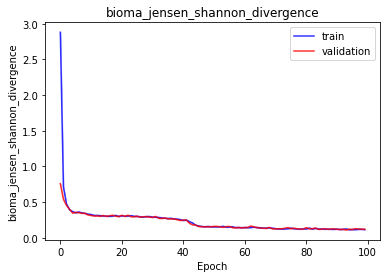

<b>domain_mse</b>: 878693952.0000 (min: 878693952.0000, max: 878693952.0000)

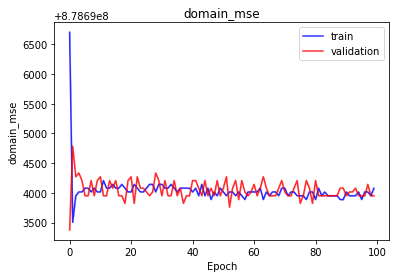

<b>domain_mae</b>: 4677.9307 (min: 4677.9307, max: 4677.9307)

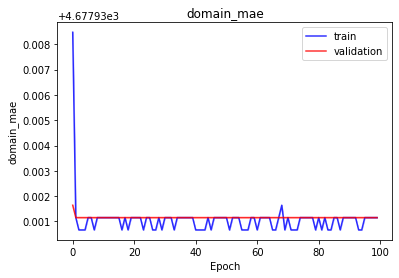

<b>domain_mape</b>: 15439.3398 (min: 15439.3398, max: 15439.3398)

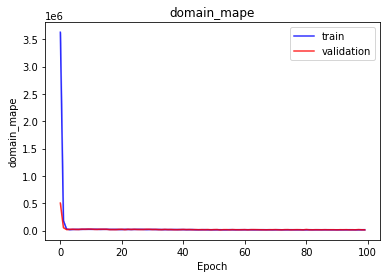

<b>domain_BrayCurtis</b>: 0.2251 (min: 0.2251, max: 0.2251)

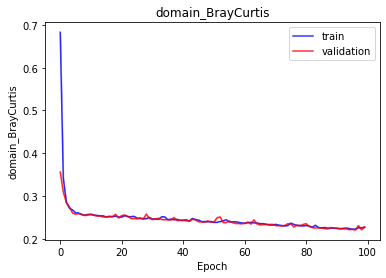

<b>domain_pearson_corr</b>: 0.8893 (min: 0.8893, max: 0.8893)

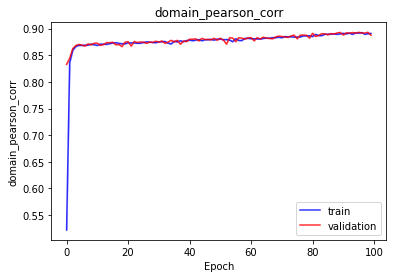

<b>domain_jensen_shannon_divergence</b>: 0.3739 (min: 0.3739, max: 0.3739)

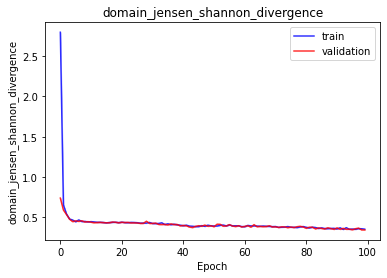

<b>latent_mae</b>: 0.0273 (min: 0.0273, max: 0.0273)

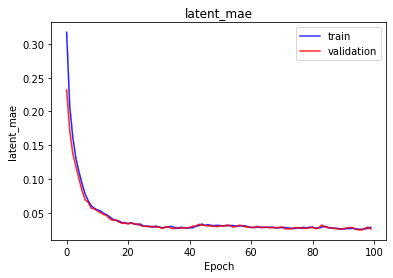

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.35011351108551025 | 0.35011351108551025 | 0.35011351108551025 |
| bioma_loss | 0.09774545580148697 | 0.09774545580148697 | 0.09774545580148697 |
| domain_loss | 0.22511623799800873 | 0.22511623799800873 | 0.22511623799800873 |
| latent_loss | 0.027251793071627617 | 0.027251793071627617 | 0.027251793071627617 |
| bioma_mse | 878693696.0 | 878693696.0 | 878693696.0 |
| bioma_mae | 4677.9306640625 | 4677.9306640625 | 4677.9306640625 |
| bioma_mape | 20991.068359375 | 20991.068359375 | 20991.068359375 |
| bioma_BrayCurtis | 0.09774545580148697 | 0.09774545580148697 | 0.09774545580148697 |
| bioma_pearson_corr | 0.9883158206939697 | 0.9883158206939697 | 0.9883158206939697 |
| bioma_jensen_shannon_divergence | 0.12440544366836548 | 0.12440544366836548 | 0.12440544366836548 |
| domain_mse | 878693952.0 | 878693952.0 | 878693952.0 |
| domain_mae | 4677.9306640625 | 4677.9306640625 | 4677.9306640625 |
| domain_mape | 15439.33984375 | 15439.33984375 | 15439.33984375 |
| domain_BrayCurtis | 0.22511623799800873 | 0.22511623799800873 | 0.22511623799800873 |
| domain_pearson_corr | 0.8892920613288879 | 0.8892920613288879 | 0.8892920613288879 |
| domain_jensen_shannon_divergence | 0.37386515736579895 | 0.37386515736579895 | 0.37386515736579895 |
| latent_mae | 0.027251793071627617 | 0.027251793071627617 | 0.027251793071627617 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.27266910672187805 | 0.27266910672187805 | 0.27266910672187805 |
| pearson_corr | 0.8654816746711731 | 0.8654816746711731 | 0.8654816746711731 |
| jensen_shannon_divergence | 0.4205506145954132 | 0.4205506145954132 | 0.4205506145954132 |


In [23]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [24]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_Combinedcomida_familia.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_Combinedcomida_familia')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_Combinedcomida_familia')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_Combinedcomida_familia')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_Combined_familia.csv",index=False)

### Order

In [25]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>95</b></p>

<b>loss</b>: 0.1416 (min: 0.1416, max: 0.1416)

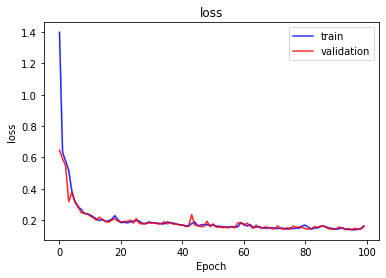

<b>bioma_loss</b>: 0.0372 (min: 0.0372, max: 0.0372)

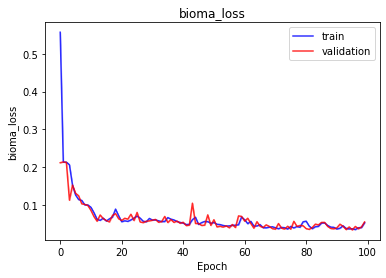

<b>domain_loss</b>: 0.0925 (min: 0.0925, max: 0.0925)

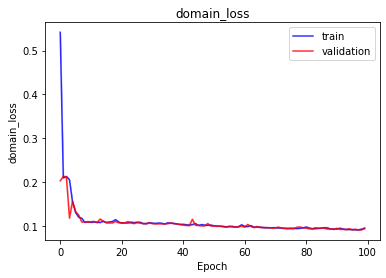

<b>latent_loss</b>: 0.0120 (min: 0.0120, max: 0.0120)

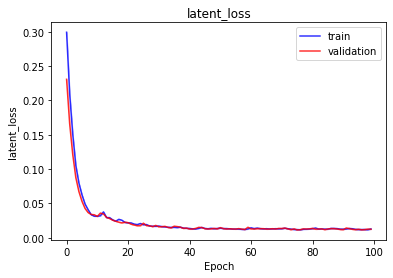

<b>bioma_mse</b>: 2787705088.0000 (min: 2787705088.0000, max: 2787705088.0000)

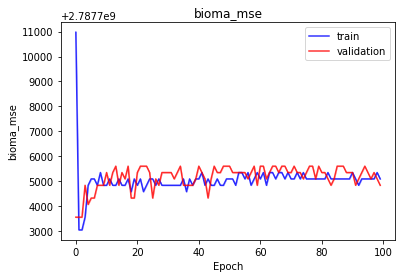

<b>bioma_mae</b>: 9028.4541 (min: 9028.4541, max: 9028.4541)

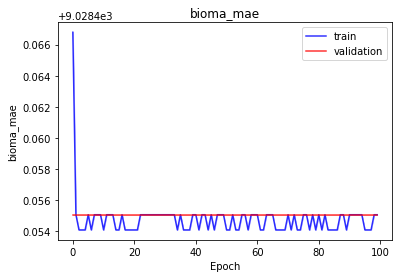

<b>bioma_mape</b>: 22127.0996 (min: 22127.0996, max: 22127.0996)

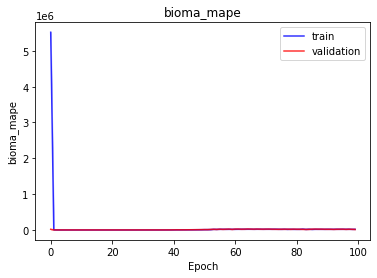

<b>bioma_BrayCurtis</b>: 0.0372 (min: 0.0372, max: 0.0372)

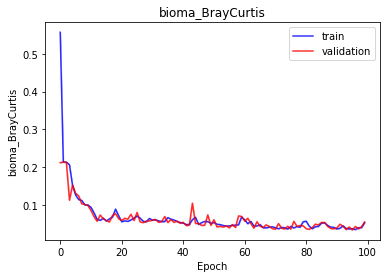

<b>bioma_pearson_corr</b>: 0.9976 (min: 0.9976, max: 0.9976)

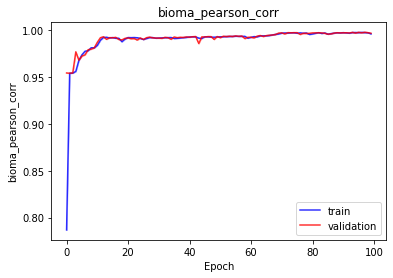

<b>bioma_jensen_shannon_divergence</b>: 0.0485 (min: 0.0485, max: 0.0485)

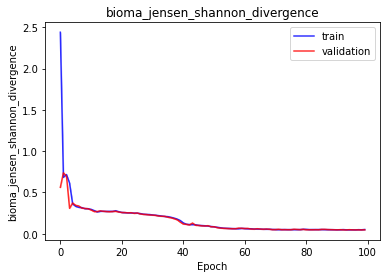

<b>domain_mse</b>: 2787705344.0000 (min: 2787705344.0000, max: 2787705344.0000)

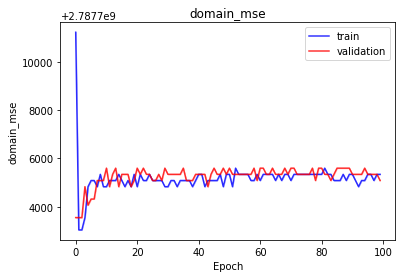

<b>domain_mae</b>: 9028.4541 (min: 9028.4541, max: 9028.4541)

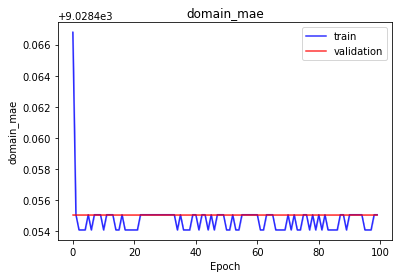

<b>domain_mape</b>: 17612.7715 (min: 17612.7715, max: 17612.7715)

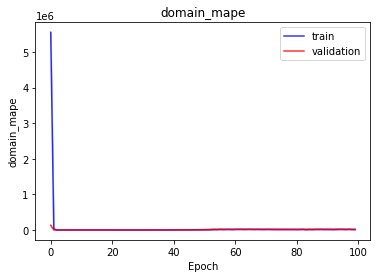

<b>domain_BrayCurtis</b>: 0.0925 (min: 0.0925, max: 0.0925)

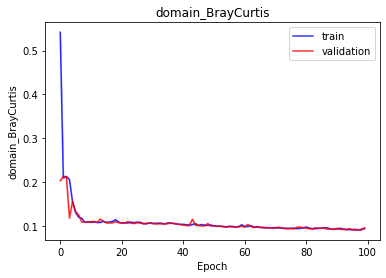

<b>domain_pearson_corr</b>: 0.9814 (min: 0.9814, max: 0.9814)

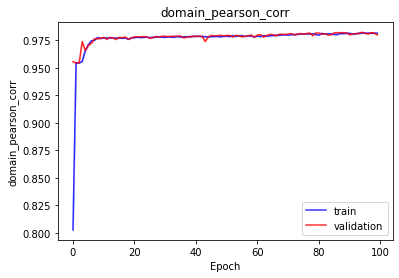

<b>domain_jensen_shannon_divergence</b>: 0.0906 (min: 0.0906, max: 0.0906)

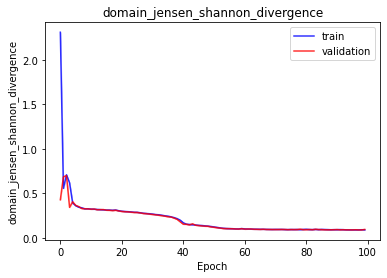

<b>latent_mae</b>: 0.0120 (min: 0.0120, max: 0.0120)

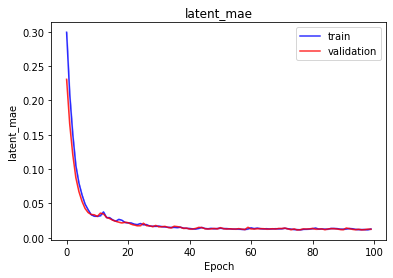

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.1415911465883255 | 0.1415911465883255 | 0.1415911465883255 |
| bioma_loss | 0.03715581074357033 | 0.03715581074357033 | 0.03715581074357033 |
| domain_loss | 0.09246086329221725 | 0.09246086329221725 | 0.09246086329221725 |
| latent_loss | 0.011974485591053963 | 0.011974485591053963 | 0.011974485591053963 |
| bioma_mse | 2787705088.0 | 2787705088.0 | 2787705088.0 |
| bioma_mae | 9028.4541015625 | 9028.4541015625 | 9028.4541015625 |
| bioma_mape | 22127.099609375 | 22127.099609375 | 22127.099609375 |
| bioma_BrayCurtis | 0.03715581074357033 | 0.03715581074357033 | 0.03715581074357033 |
| bioma_pearson_corr | 0.9976431131362915 | 0.9976431131362915 | 0.9976431131362915 |
| bioma_jensen_shannon_divergence | 0.04845229536294937 | 0.04845229536294937 | 0.04845229536294937 |
| domain_mse | 2787705344.0 | 2787705344.0 | 2787705344.0 |
| domain_mae | 9028.4541015625 | 9028.4541015625 | 9028.4541015625 |
| domain_mape | 17612.771484375 | 17612.771484375 | 17612.771484375 |
| domain_BrayCurtis | 0.09246086329221725 | 0.09246086329221725 | 0.09246086329221725 |
| domain_pearson_corr | 0.9814321398735046 | 0.9814321398735046 | 0.9814321398735046 |
| domain_jensen_shannon_divergence | 0.09064888209104538 | 0.09064888209104538 | 0.09064888209104538 |
| latent_mae | 0.011974485591053963 | 0.011974485591053963 | 0.011974485591053963 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.1299680769443512 | 0.1299680769443512 | 0.1299680769443512 |
| pearson_corr | 0.9651240706443787 | 0.9651240706443787 | 0.9651240706443787 |
| jensen_shannon_divergence | 0.15079227089881897 | 0.15079227089881897 | 0.15079227089881897 |


In [26]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [27]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_Combinedcomida_orden.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_Combinedcomida_gorden')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_Combinedcomida_orden')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_Combinedcomida_orden')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_Combined_orden.csv",index=False)

### Class

In [28]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>96</b></p>

<b>loss</b>: 0.1373 (min: 0.1373, max: 0.1373)

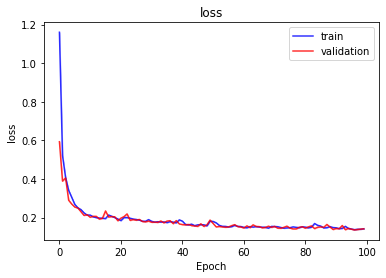

<b>bioma_loss</b>: 0.0392 (min: 0.0392, max: 0.0392)

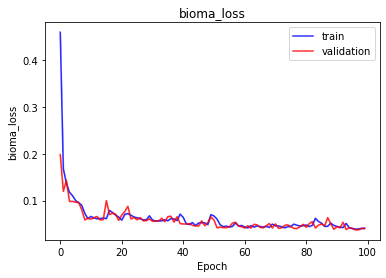

<b>domain_loss</b>: 0.0869 (min: 0.0869, max: 0.0869)

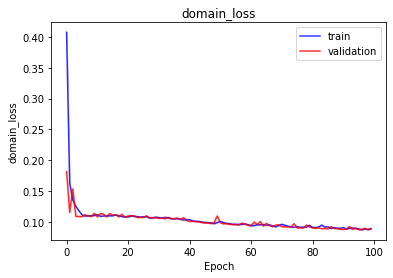

<b>latent_loss</b>: 0.0112 (min: 0.0112, max: 0.0112)

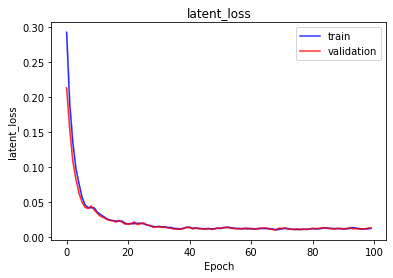

<b>bioma_mse</b>: 4695274496.0000 (min: 4695274496.0000, max: 4695274496.0000)

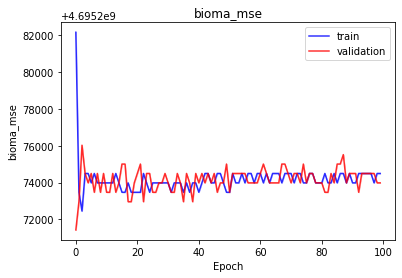

<b>bioma_mae</b>: 15206.2598 (min: 15206.2598, max: 15206.2598)

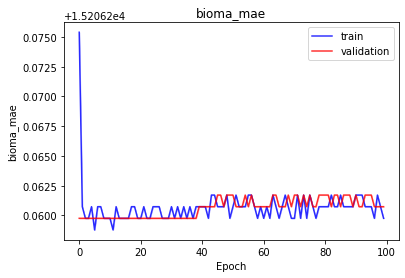

<b>bioma_mape</b>: 23921.2891 (min: 23921.2891, max: 23921.2891)

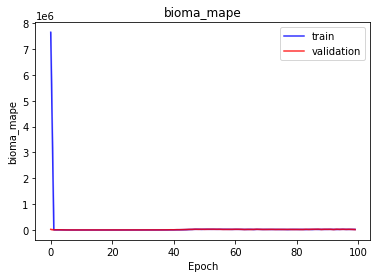

<b>bioma_BrayCurtis</b>: 0.0392 (min: 0.0392, max: 0.0392)

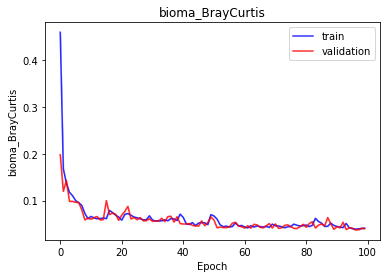

<b>bioma_pearson_corr</b>: 0.9974 (min: 0.9974, max: 0.9974)

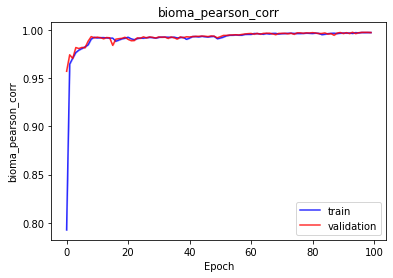

<b>bioma_jensen_shannon_divergence</b>: 0.0445 (min: 0.0445, max: 0.0445)

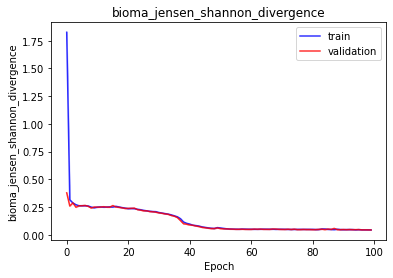

<b>domain_mse</b>: 4695274496.0000 (min: 4695274496.0000, max: 4695274496.0000)

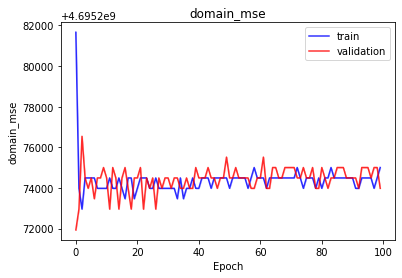

<b>domain_mae</b>: 15206.2598 (min: 15206.2598, max: 15206.2598)

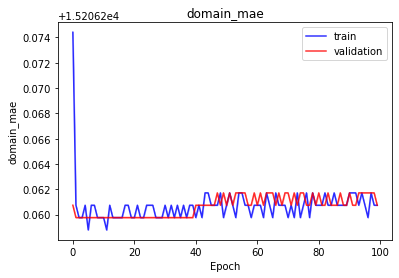

<b>domain_mape</b>: 19875.3281 (min: 19875.3281, max: 19875.3281)

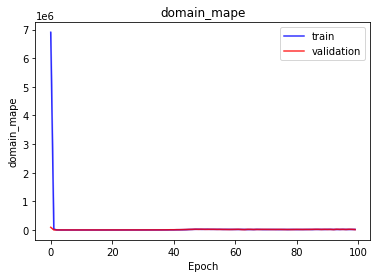

<b>domain_BrayCurtis</b>: 0.0869 (min: 0.0869, max: 0.0869)

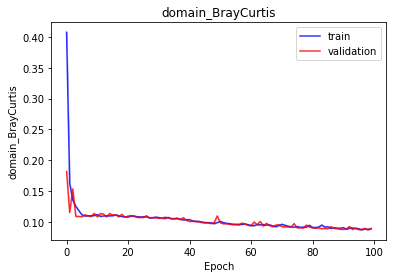

<b>domain_pearson_corr</b>: 0.9823 (min: 0.9823, max: 0.9823)

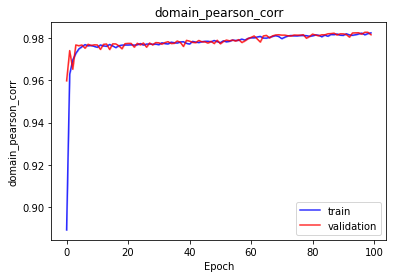

<b>domain_jensen_shannon_divergence</b>: 0.0824 (min: 0.0824, max: 0.0824)

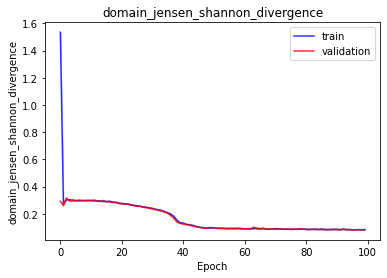

<b>latent_mae</b>: 0.0112 (min: 0.0112, max: 0.0112)

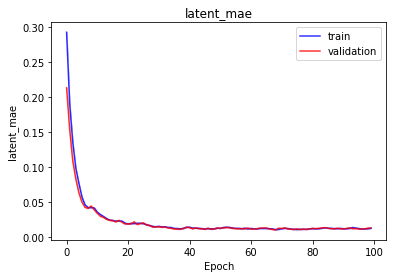

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.13730253279209137 | 0.13730253279209137 | 0.13730253279209137 |
| bioma_loss | 0.039190396666526794 | 0.039190396666526794 | 0.039190396666526794 |
| domain_loss | 0.08690321445465088 | 0.08690321445465088 | 0.08690321445465088 |
| latent_loss | 0.01120890025049448 | 0.01120890025049448 | 0.01120890025049448 |
| bioma_mse | 4695274496.0 | 4695274496.0 | 4695274496.0 |
| bioma_mae | 15206.259765625 | 15206.259765625 | 15206.259765625 |
| bioma_mape | 23921.2890625 | 23921.2890625 | 23921.2890625 |
| bioma_BrayCurtis | 0.039190396666526794 | 0.039190396666526794 | 0.039190396666526794 |
| bioma_pearson_corr | 0.9974441528320312 | 0.9974441528320312 | 0.9974441528320312 |
| bioma_jensen_shannon_divergence | 0.044486816972494125 | 0.044486816972494125 | 0.044486816972494125 |
| domain_mse | 4695274496.0 | 4695274496.0 | 4695274496.0 |
| domain_mae | 15206.259765625 | 15206.259765625 | 15206.259765625 |
| domain_mape | 19875.328125 | 19875.328125 | 19875.328125 |
| domain_BrayCurtis | 0.08690321445465088 | 0.08690321445465088 | 0.08690321445465088 |
| domain_pearson_corr | 0.9822525978088379 | 0.9822525978088379 | 0.9822525978088379 |
| domain_jensen_shannon_divergence | 0.08235257118940353 | 0.08235257118940353 | 0.08235257118940353 |
| latent_mae | 0.01120890025049448 | 0.01120890025049448 | 0.01120890025049448 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.13412798941135406 | 0.13412798941135406 | 0.13412798941135406 |
| pearson_corr | 0.9657945036888123 | 0.9657945036888123 | 0.9657945036888123 |
| jensen_shannon_divergence | 0.1331290304660797 | 0.1331290304660797 | 0.1331290304660797 |


In [29]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [30]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_Combinedcomida_clase.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_Combinedcomida_clase')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_Combinedcomida_clase')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_Combinedcomida_clase')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_Combined_clase.csv",index=False)

### Phylum

In [31]:
#Cargamos los datos
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["F_TOTAL","F_CITMLB","F_OTHER","F_JUICE","V_TOTAL","V_DRKGR","V_REDOR_TOTAL","V_REDOR_TOMATO","V_REDOR_OTHER","V_STARCHY_TOTAL","V_STARCHY_POTATO","V_STARCHY_OTHER","V_OTHER",\
                     "V_LEGUMES","G_TOTAL","G_WHOLE","G_REFINED","PF_TOTAL","PF_MPS_TOTAL","PF_MEAT","PF_CUREDMEAT","PF_ORGAN","PF_POULT","PF_SEAFD_HI","PF_SEAFD_LOW","PF_EGGS","PF_SOY","PF_NUTSDS",\
                     "PF_LEGUMES","D_TOTAL","D_MILK","D_YOGURT","D_CHEESE","OILS","SOLID_FATS","ADD_SUGARS","A_DRINKS"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='datos-remoto/comidas/metadatos_comidas.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.1337 (min: 0.1337, max: 0.1337)

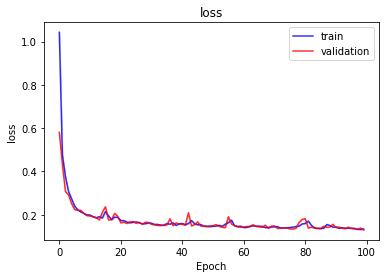

<b>bioma_loss</b>: 0.0367 (min: 0.0367, max: 0.0367)

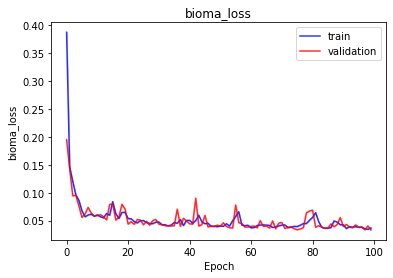

<b>domain_loss</b>: 0.0860 (min: 0.0860, max: 0.0860)

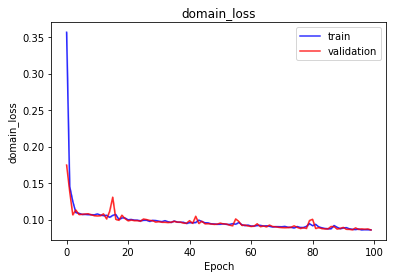

<b>latent_loss</b>: 0.0110 (min: 0.0110, max: 0.0110)

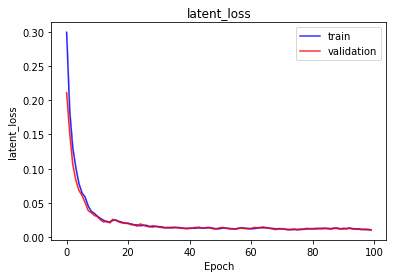

<b>bioma_mse</b>: 9952978944.0000 (min: 9952978944.0000, max: 9952978944.0000)

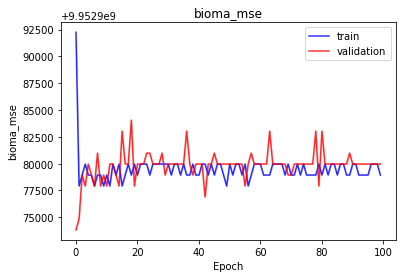

<b>bioma_mae</b>: 32181.6953 (min: 32181.6953, max: 32181.6953)

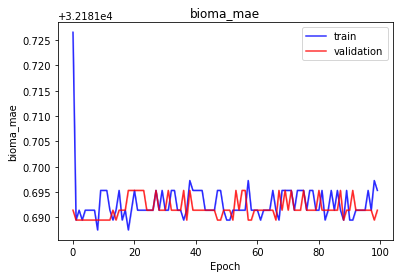

<b>bioma_mape</b>: 28290.0020 (min: 28290.0020, max: 28290.0020)

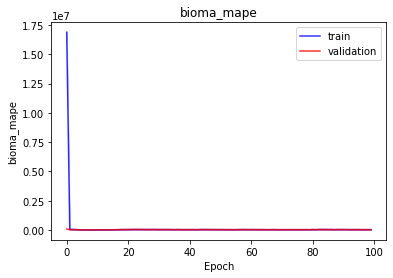

<b>bioma_BrayCurtis</b>: 0.0367 (min: 0.0367, max: 0.0367)

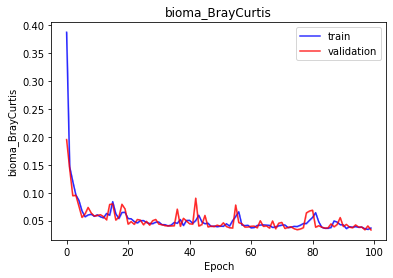

<b>bioma_pearson_corr</b>: 0.9972 (min: 0.9972, max: 0.9972)

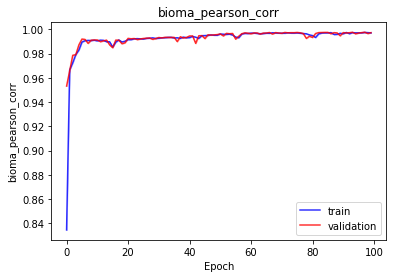

<b>bioma_jensen_shannon_divergence</b>: 0.0278 (min: 0.0278, max: 0.0278)

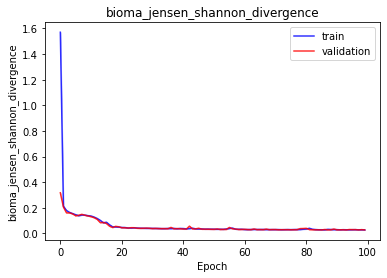

<b>domain_mse</b>: 9952978944.0000 (min: 9952978944.0000, max: 9952978944.0000)

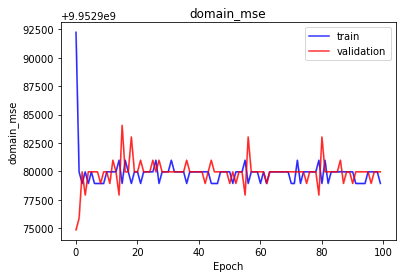

<b>domain_mae</b>: 32181.6953 (min: 32181.6953, max: 32181.6953)

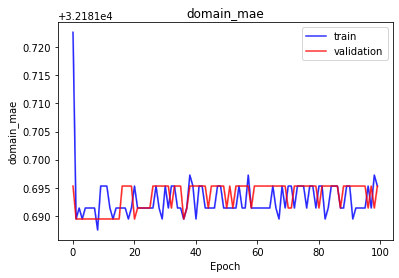

<b>domain_mape</b>: 26605.4336 (min: 26605.4336, max: 26605.4336)

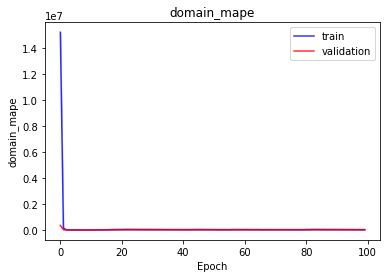

<b>domain_BrayCurtis</b>: 0.0860 (min: 0.0860, max: 0.0860)

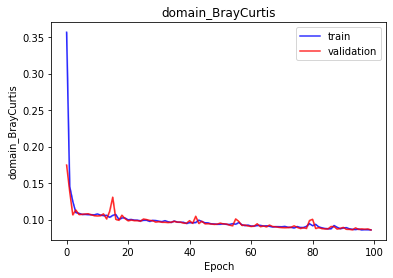

<b>domain_pearson_corr</b>: 0.9809 (min: 0.9809, max: 0.9809)

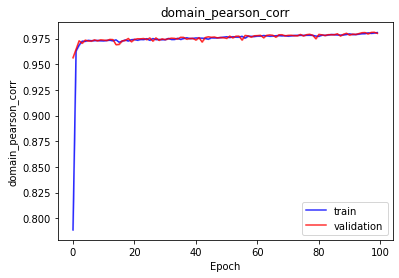

<b>domain_jensen_shannon_divergence</b>: 0.0651 (min: 0.0651, max: 0.0651)

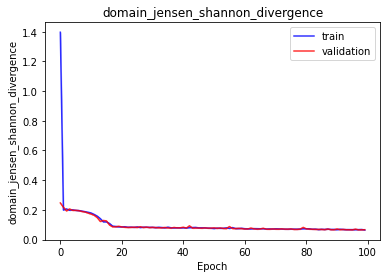

<b>latent_mae</b>: 0.0110 (min: 0.0110, max: 0.0110)

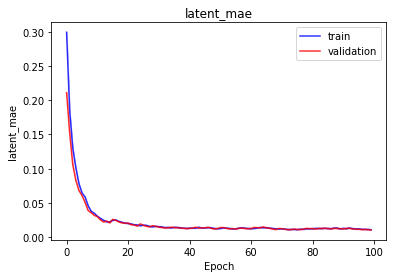

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.133735790848732 | 0.133735790848732 | 0.133735790848732 |
| bioma_loss | 0.03673103079199791 | 0.03673103079199791 | 0.03673103079199791 |
| domain_loss | 0.08598525077104568 | 0.08598525077104568 | 0.08598525077104568 |
| latent_loss | 0.011019520461559296 | 0.011019520461559296 | 0.011019520461559296 |
| bioma_mse | 9952978944.0 | 9952978944.0 | 9952978944.0 |
| bioma_mae | 32181.6953125 | 32181.6953125 | 32181.6953125 |
| bioma_mape | 28290.001953125 | 28290.001953125 | 28290.001953125 |
| bioma_BrayCurtis | 0.03673103079199791 | 0.03673103079199791 | 0.03673103079199791 |
| bioma_pearson_corr | 0.9971786141395569 | 0.9971786141395569 | 0.9971786141395569 |
| bioma_jensen_shannon_divergence | 0.02775036357343197 | 0.02775036357343197 | 0.02775036357343197 |
| domain_mse | 9952978944.0 | 9952978944.0 | 9952978944.0 |
| domain_mae | 32181.6953125 | 32181.6953125 | 32181.6953125 |
| domain_mape | 26605.43359375 | 26605.43359375 | 26605.43359375 |
| domain_BrayCurtis | 0.08598525077104568 | 0.08598525077104568 | 0.08598525077104568 |
| domain_pearson_corr | 0.9808804392814636 | 0.9808804392814636 | 0.9808804392814636 |
| domain_jensen_shannon_divergence | 0.06514445692300797 | 0.06514445692300797 | 0.06514445692300797 |
| latent_mae | 0.011019520461559296 | 0.011019520461559296 | 0.011019520461559296 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11578935384750366 | 0.11578935384750366 | 0.11578935384750366 |
| pearson_corr | 0.9731850028038025 | 0.9731850028038025 | 0.9731850028038025 |
| jensen_shannon_divergence | 0.09109515696763992 | 0.09109515696763992 | 0.09109515696763992 |


In [32]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [33]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_Combinedcomida_filo.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_Combinedcomida_filo')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_Combinedcomida_filo')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_Combinedcomida_filo')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/comidas/FI/FI_Combined_filo.csv",index=False)